# Notebook X: exoplanet occurrence rates

## Learning objectives
- Work with large amounts of TESS data

## Introduction
Studying exoplanet demographics lets us tackle some of the biggest questions in exoplanet science: How do planets form, and how do they migrate migrate? Are there any exoplanets that are like the Earth? [todo: add more explanation of what studying exoplanet demographics means? at least explain TESS more.]

TIKE is an excellent resource for computing occurrence rates. There are other resources that explain TIKE elsewhere; we summarize some of the main TIKE benefits in this case below:

- close to MAST data, means that accessing lightcurves is faster.
- don't have to download data to your own computer, saving *storage* too.
- don't have to use your own compute. multi-core situation.
- the science environments are already set up. you don't have to spend time wrangling with environments.


[todo: increase or decrease the amount that TIKE is talked up?]

reference: [Beleznay & Kunimoto 2022](https://academic.oup.com/mnras/article/516/1/75/6654884).

# 1. Import packages, set constants

Before diving into planet-finding, we need to import some necessary packages.

- `astropy` contains a number of utility functions for working with astronomical data.
- `astroquery` lets us easily query the astronomical databases that contain the TESS lightcurves.
- `numpy` is used for array manipulation.
- `matplotlib.pyplot` is used to display images and plot datasets.
- `tqdm` is a lightweight progress bar that we can use to track how long our calculations will take.
- `pandas` let us interact easily with CSV files that we'll be downliading.
- `os` and `concurrent` let us make informed choiced when multithreading.

In [37]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.timeseries import BoxLeastSquares


from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.exceptions import InvalidQueryError


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


import os
from concurrent.futures import ThreadPoolExecutor, as_completed

We will also *install* one package into our environment: the `batman` package. This tool will let us easily model exoplanet transits during our planet searches.

In [38]:
!pip install batman-package

With our package installed, we can safeuly import it.

In [39]:
import batman
from batman import transitmodel

We'll now set a few constants and conversion factors so that we can use them later on.

In [36]:
G = const.G.si.value
days_to_seconds = (u.day).to(u.s)
r_earth_to_meters = (u.R_earth).to(u.m)
m_sun_kg = (u.M_sun).to(u.kg)
r_sun_m = (u.R_sun).to(u.m)

We'll also make sure that we retrieve cloud files from AWS, making our data access stage much faster.

In [ ]:
# Important: ensure files are retrieved from AWS 
Observations.enable_cloud_dataset(provider='AWS')

# 2. Find stars

Generally, the first step to finding planets is figuring out what host stars you want to search for orbiting planets. In this study, we want to find the occurrence of hot Jupiters around Sun-like stars. We'll make some cuts so that we're looking for bright, high-gravity, solar-mass stars:

- *bright*: TESS was designed to look for transits around bright stars. These stars' TESS data will have high signal to noise ratios, so we have better chances of finding planetary signals in them.
- *high-gravity*: especially low-gravity stars tend to be evolved off the stellar main-sequence, and therefore not very Sun-like.
- *solar-mass*: solar-mass stars on the stellar main sequence tend to be quite solar.

To find these stars, we'll query the TESS Candidate Target List (CTL) — a list of stars pre-selected by the TESS team to be likely good targets for transit detection (e.g., bright, low flux contamination).

In [6]:
%%time

catalog_data = Catalogs.query_criteria(catalog="Ctl",
                                       Tmag=[0, 10.5], # remember, lower magnitudes are brighter than higher ones!
                                      logg=[4.1,400], # solar logg ~ 4.4
                                      mass=[0.8, 1.05]) # these masses are in solar radii

CPU times: user 17.1 s, sys: 1.95 s, total: 19 s
Wall time: 32.9 s


Let's take a look at this catalog data.

In [7]:
catalog_data

ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str7,float64,float64,str7,float64,float64,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str10
83959472,20190415,--,2263-00585-1,618-000115,00021325+3332024,1237663308526845988,J000213.34+333202.7,2875033176455625856,48345553,--,STAR,tmgaia2,0.555252893670364,33.5339825229705,tmgaia2,100.97,0.0431288,33.9682,0.0257407,gaia2,12.1159,0.0338534,gaia2,111.30124792504,-28.2237859843783,15.2443980491818,30.2406314864645,11.295,0.087,10.347,0.007,14.2869,0.00538347,13.3056,0.00767082,13.5284,0.00867598,13.7071,0.010485,11.9411,0.0102286,8.909,0.023,8.566,0.02,8.421,0.015,AAA-212-111-000-0-0,nan,8.379,0.021,8.42,0.021,8.355,0.022,8.357,nan,10.2075,0.000531,9.6831,0.006,gbprp,gaia2,5223.0,120.467,4.56881,0.0814866,nan,nan,0.811567,0.0454021,0.89,0.10809,1.66501,0.384411,DWARF,0.4415947,0.0105982,82.3402,0.23125,0.0,0.0,87,1.31188488,--,--,0.00279704212771259,0.0,0.0,--,0.0683117,0.147868,0.0391538,0.0516503,0.252086,0.516736,0.0827373,0.0802359,0.0113781,0.0098183,0.2306,0.2319,bj2018,136.462,104.472,dered0,10.6464,0.001566,9.63191,0.001536,1,--,tycho2v3,tycho2b3,planetcandidate,0.698599013141748,0.39930808270737,0.555774431197831,33.5341287760356,0.0242168607044241,0.0161624951264822,1,0,5880
117929446,20190415,84,1735-01423-1,590-000042,00010057+2753109,--,J000100.76+275310.7,2854774262396590080,46596233,--,STAR,tmgaia2,0.252424732418509,27.8863309497249,tmgaia2,223.943,0.0533403,-4.89525,0.0255566,gaia2,18.8693,0.0350665,gaia2,109.528665672947,-33.6695323056449,12.108400593785,25.3137452847069,10.367,0.054,9.61,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.104,0.029,7.715,0.026,7.6,0.018,AAA-111-111-000-0-0,nan,7.513,0.031,7.612,0.019,7.567,0.018,7.479,0.119,9.37813,0.000307,8.8397,0.006,gbprp,gaia2,5148.0,120.733,4.58053,0.083459,nan,nan,0.791644,0.0453668,0.87,0.103709,1.75359,0.411916,DWARF,0.396559983,0.009599475,52.9152,0.0989,0.0,0.0,61,0.000921181636,--,--,0.00561603334132626,0.0,0.0,--,0.107202,0.100217,0.0371668,0.0535668,0.491137,0.332694,0.098058,0.06886,0.00876735,0.0104316,0.0987,0.0991,bj2018,131.344,110.122,dered0,9.83911,0.001003,8.79446,0.001039,1,--,hipvmag,tycho2b3,planetcandidate,0.852379725114054,0.396443868231685,0.253515606781726,27.8863098772474,0.0293312144149789,0.0158399132955867,1,0,10015
238302775,20190415,--,1184-01933-1,561-000

In [8]:
# next, download a single star from this catalog to inspect the data type we're working with.

In [9]:
%%time
TESS_table = Observations.query_criteria(target_name=catalog_data['ID'][2]
                                         , obs_collection="TESS"
                                         , dataproduct_type='timeseries'
                                         ) 

data_products = Observations.get_product_list(TESS_table) 


CPU times: user 58 ms, sys: 2.6 ms, total: 60.6 ms
Wall time: 479 ms


In [10]:
# Keep only the science products
filtered = Observations.filter_products(data_products, productType="SCIENCE")

# Be selective about the columns we display
cols = ['obs_id', 'description', 'productSubGroupDescription']

# Look at the first five rows of the filtered results
filtered[0:10][cols]
ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
# ex_id = filtered['obs_id'][0]

lc_prod = Observations.filter_products(data_products
                                      , obs_id = ex_id   
                                      )
# Get the cloud uris for these files
lc_uri = Observations.get_cloud_uris(lc_prod)[0]

#open the lc file
lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})



/opt/conda/envs/tess/lib/python3.11/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [11]:
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

Text(0.5, 0, 'TIME  (BJD-2457000)')

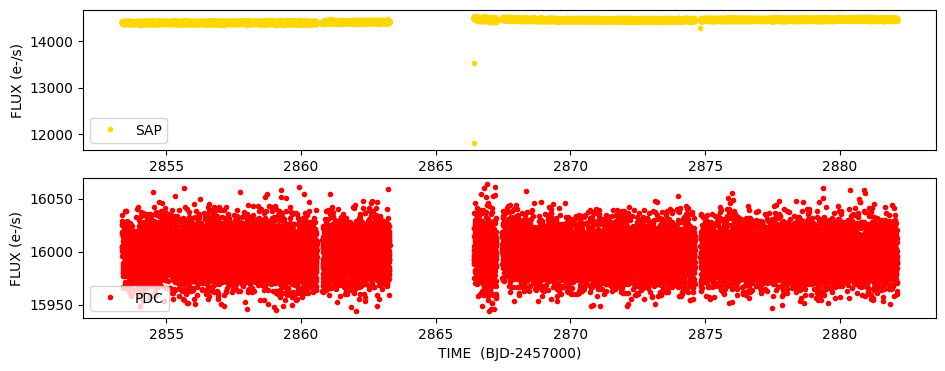

In [12]:
sapflux = lc['SAP_FLUX'] #SAP flux column
pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
time_lc = lc['TIME'] #time column

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

# Then: loop over and download all the files

In [13]:
# explain that we're writing a function here. and lay out what each step does. first, here's the slow version.

In [14]:
# todo: bulk query. multithreading and target_name each did a factor of 10 speedup. can i do one more factor of 10?

In [15]:
# todo: explain all this cool multithreading that we're doing.

In [16]:
def fetch_and_save_data(catalog_id):
    TESS_table = Observations.query_criteria(target_name=catalog_id
                                             , obs_collection="TESS"
                                             , dataproduct_type='timeseries'
                                             ) 
    try:
        data_products = Observations.get_product_list(TESS_table) 
    except InvalidQueryError:
        return
        
    # Keep only the science products
    filtered = Observations.filter_products(data_products, productType="SCIENCE")
    
    # Be selective about the columns we display
    cols = ['obs_id', 'description', 'productSubGroupDescription']
    
    # Look at the first five rows of the filtered results
    filtered[0:10][cols]
    ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
    
    lc_prod = Observations.filter_products(data_products
                                          , obs_id = ex_id   
                                          , productSubGroupDescription = "LC")
    
    # Get the cloud uris for these files
    lc_uri = Observations.get_cloud_uris(lc_prod)[0]

    #open the lc file
    lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})
    
    #Take a peek at the FITS file we downloaded
    lc = lc_fits[1].data
    sapflux = lc['SAP_FLUX'] #SAP flux column
    pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
    pdcflux_err = lc['PDCSAP_FLUX_ERR']
    time_lc = lc['TIME'] #time column
    
    np.save(f'lc_data/{catalog_id}.npy', [time_lc, pdcflux, pdcflux_err])



In [17]:
fetch_and_save_data(catalog_data['ID'][0])

In [ ]:
# explain how to set the max number of workers
os.cpu_count() 


In [19]:

# Use ThreadPoolExecutor to download files in parallel
total_tasks = len(catalog_data['ID'][::100])
progress_bar = tqdm(total=total_tasks, position=0, leave=True)

max_workers = 5  # Adjust this based on your system's capabilities

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(fetch_and_save_data, catalog_id) for catalog_id in catalog_data['ID'][::100]]
    for future in as_completed(futures):
        progress_bar.update(1)
        
# Optionally wait for all futures to complete
for future in futures:
    future.result()

  0%|          | 0/531 [00:00<?, ?it/s]WARNING: NoResultsWarning: Query returned no results. [astroquery.mast.discovery_portal]
2024-09-02 00:27:16,329 - WARNING - NoResultsWarning: Query returned no results.
100%|██████████| 531/531 [02:01<00:00,  3.71it/s]

In [20]:
# about 1 hour to download all the correct lightcurves.

In [21]:
# todo: going to continue going forward with the current plan without all the stars, so that downloading is tenable.
# just download 1/10 of the stars that I was going to work with initially.

# then: search the lightcurves for planets.
- explain what the box-least squares algorithm is
- explain how we parallelize it
- use lightkurve (or faster equivalent) to find the best-fit periods, sizes, and signal strengths of planetary signals
- store in array or something similar

In [22]:
time, flux, flux_err  = np.load('lc_data/293465600.npy')

time = time[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]

In [23]:
model = BoxLeastSquares(time, flux, flux_err)

In [24]:
periods = np.linspace(0.5, 10, 1000)  # Example: searching periods between 0.5 and 10 days. is 1000 enough?


In [25]:
%%timeit
results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)


219 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
results = model.power(periods, 0.1, objective="snr")  # The second argument is the duration of the transit (in days)

In [27]:
%%timeit
results = model.autopower(.1, objective="snr")  # The second argument is the duration of the transit (in days)

6.34 s ± 495 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
best_period = results.period[np.argmax(results.power)]
print("Best-fit period:", best_period)

Best-fit period: 5.188188188188189


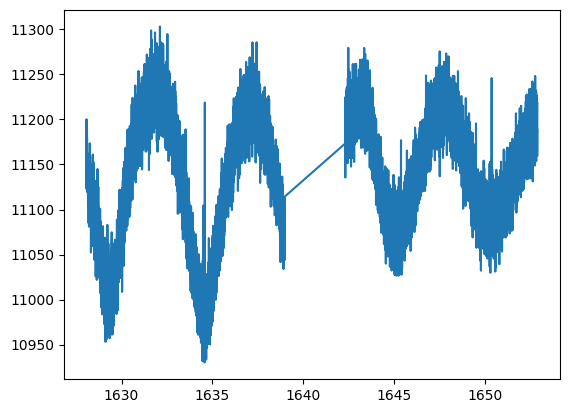

In [29]:
plt.plot(time, flux)

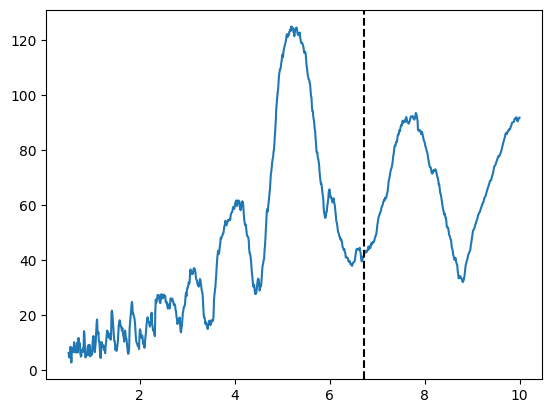

In [30]:
plt.plot(results.period, results.power)
plt.axvline(6.72, color='black', linestyle='--')

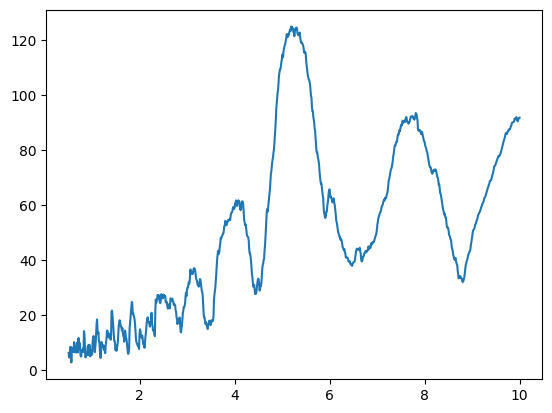

In [31]:
plt.plot(results.period, results.depth_snr)


In [32]:
max_power = np.argmax(results.power)
stats = model.compute_stats(results.period[max_power],
                            results.duration[max_power],
                            results.transit_time[max_power])

In [33]:
stats

{'transit_times': array([1629.45498647, 1634.64317466, 1639.83136285, 1645.01955104,
        1650.20773923]),
 'per_transit_count': array([69, 72,  0, 72, 72]),
 'per_transit_log_likelihood': array([2922.74173687, 4346.42974263,    0.        ,  595.71137877,
          79.72668109]),
 'depth': (101.51713648934674, 0.8131226987398122),
 'depth_phased': (-71.92695751060455, 0.7407104482663658),
 'depth_half': (5.770991608120312, 0.5534255182699351),
 'depth_odd': (113.03653242714245, 1.1365866039385186),
 'depth_even': (89.67008757748226, 1.1524824678131067),
 'harmonic_amplitude': 82.93977653569917,
 'harmonic_delta_log_likelihood': 130488.45526244337}

In [160]:
# need at least two tranits

In [8]:
def do_bls(time, flux, flux_err):
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    # todo: check even and odd
    return results, stats

In [14]:
def do_inversion_test(time, flux, flux_error):
    inverted_flux = -1 * flux + 2* np.mean(flux)
    results, stats = do_bls(time, inverted_flux, flux_err)
    return results, stats

In [150]:
periods = np.linspace(0.5, 10, 100)

In [152]:
np.geomspace(0.5, 10, 100)

array([ 0.5       ,  0.5153612 ,  0.53119434,  0.54751391,  0.56433485,
        0.58167258,  0.59954296,  0.61796236,  0.63694765,  0.65651622,
        0.67668598,  0.6974754 ,  0.71890352,  0.74098997,  0.76375496,
        0.78721935,  0.81140462,  0.83633293,  0.86202709,  0.88851063,
        0.91580782,  0.94394364,  0.97294386,  1.00283504,  1.03364454,
        1.06540059,  1.09813226,  1.13186952,  1.16664328,  1.20248537,
        1.23942861,  1.27750684,  1.31675493,  1.35720881,  1.39890553,
        1.44188327,  1.4861814 ,  1.53184047,  1.57890229,  1.62740997,
        1.67740792,  1.72894193,  1.78205919,  1.83680833,  1.8932395 ,
        1.95140438,  2.01135622,  2.07314992,  2.13684208,  2.20249101,
        2.27015683,  2.33990151,  2.41178892,  2.48588488,  2.56225724,
        2.64097595,  2.72211309,  2.80574295,  2.89194213,  2.98078955,
        3.07236658,  3.16675707,  3.26404747,  3.36432686,  3.46768708,
        3.57422277,  3.6840315 ,  3.79721381,  3.91387336,  4.03

In [153]:
periods = np.geomspace(0.5, 10, 100)  # Example: searching periods between 0.5 and 10 days. is 1000 enough?

def find_planet(ticid):
    """
    This is ourn main function to find a planet. We basically perform the box-least squares algorithm, 
    then do a simple inversion test.
    """
    time, flux, flux_err  = np.load(f'lc_data/{ticid}.npy')

    time = time[~np.isnan(flux)]
    flux_err = flux_err[~np.isnan(flux)]
    flux = flux[~np.isnan(flux)]
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    
    # do the inversion test here? if we invert it and find the transit, not good.
    if len(stats['transit_times']) >= 2 and results.depth_snr[max_power] >= 10:

        # test for variability
        inverted_results, inverted_stats = do_inversion_test(time, flux, flux_err)
        if len(inverted_stats['transit_times']) < 2 or inverted_results.depth_snr[max_power] < 10:
            return True

    # todo: The harmonic_delta_log_likelihood is the difference in log likelihood between a sinusoidal model and the transit model. If harmonic_delta_log_likelihood is greater than zero, the sinusoidal model is preferred.

            
    return False

        
        # we found a planet then!

In [23]:
find_planet('293465600')

False

# then: false positive rate -- code done!
- explain what a false positive is.
- query Gaia to get a sense for false positive rate as a backup.
- tike angle: use dask!  

In [24]:
exofop_data = pd.read_csv('https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv')

In [25]:
exofop_data.columns

Index(['TIC ID', 'TOI', 'Previous CTOI', 'Master', 'SG1A', 'SG1B', 'SG2',
       'SG3', 'SG4', 'SG5', 'ESM', 'TSM', 'Predicted Mass (M_Earth)',
       'Time Series Observations', 'Spectroscopy Observations',
       'Imaging Observations', 'TESS Disposition', 'TFOPWG Disposition',
       'TESS Mag', 'TESS Mag err', 'Planet Name', 'Pipeline Signal ID',
       'Source', 'Detection', 'RA', 'Dec', 'PM RA (mas/yr)',
       'PM RA err (mas/yr)', 'PM Dec (mas/yr)', 'PM Dec err (mas/yr)',
       'Epoch (BJD)', 'Epoch (BJD) err', 'Period (days)', 'Period (days) err',
       'Duration (hours)', 'Duration (hours) err', 'Depth (mmag)',
       'Depth (mmag) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth)', 'Planet Radius (R_Earth) err',
       'Planet Insolation (Earth Flux)', 'Planet Equil Temp (K)', 'Planet SNR',
       'Stellar Distance (pc)', 'Stellar Distance (pc) err',
       'Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
       'Stellar log(g) (cm/s^2)', 'Stellar 

In [35]:
# first, select the stars in our mass bin

m_low, m_high = [0.8, 1.05]

exofop_data_massbin = exofop_data[(exofop_data['Stellar Mass (M_Sun)'] > m_low) & (exofop_data['Stellar Mass (M_Sun)']< m_high)]

exofop_data_massbin['TFOPWG Disposition']

4       KP
7       KP
8       KP
9       KP
10      KP
        ..
7184    PC
7189    PC
7193    PC
7199    PC
7204    PC
Name: TFOPWG Disposition, Length: 1938, dtype: object

In [37]:
def calc_fpr(exofop_data):
    dispositions = exofop_data_massbin['TFOPWG Disposition']
    n_apc = len(dispositions[dispositions=='APC'])
    n_fp = len(dispositions[dispositions=='FP'])
    n_cp = len(dispositions[dispositions=='CP'])
    n_kp = len(dispositions[dispositions=='KP'])

    return  (n_fp + n_apc) / (n_fp + n_apc + n_cp + n_kp)

In [38]:
calc_fpr(exofop_data_massbin)

0.40327868852459015

# Then: account for completeness (transit probability)
- explain that not all planets transit. emphasize that this is simply a geometric effect, and we can account for it quickly and simply with a geometric factor.
- (if we want, we could derive this factor — it's maybe a 5 line derivation)
- tike angle: parallelize.

In [130]:
@numba.njit
def calc_a(mstar, period):
    return np.power(G * mstar  * period**2 / (4 * np.pi**2), 1/3)

In [9]:
# pre-allocating an array is always faster : )
Ptr_arr = np.zeros(len(catalog_data))

for i, star in tqdm(enumerate(catalog_data), total=len(catalog_data)):
    periods_random = np.random.uniform(0.9, 10, 100) # in days 
    radii_random = np.random.uniform(9, 28, 100) # in earth radii 

    periods_random_seconds = periods_random * days_to_seconds
    radii_random_meters = radii_random * r_earth_to_meters

    # convert periods to 
    Ms = catalog_data['mass'][0] * m_sun_kg
    Rs = catalog_data['rad'][0] * r_sun_m
    a = calc_a(Ms, periods_random_seconds)
    
    Ptr = 0.9 * (Rs + radii_random_meters)/a
    Ptr_ave = np.mean(Ptr)

    Ptr_arr[i] = Ptr_ave



100%|██████████| 53056/53056 [00:08<00:00, 5964.62it/s]


In [10]:
Ptr_arr

array([0.08659875, 0.08491721, 0.0828631 , ..., 0.08176432, 0.09056956,
       0.08338458])

# then: inject and recover?
- if this doesn't take too long, explain why injection and recovery matters — i.e., we want to know how sensitive we *would* be to a certain signal strength.
- inject transit signals with the batman package
- try to recover them with the simple pipeline that we wrote above. parallelize on multiple cores to make this faster. that's the TIKE angle.

In [122]:
import numba

In [123]:
def calc_inclination(b, a, rstar):
    i = np.arccos(rstar * b / a)
    return np.degrees(i)

In [138]:
def calc_planet_lc(period, radius, b, a, rstar, time, inc, phase_start):
    """

    just give everything in si...except for period, in days!
    """
    
    params = batman.transitmodel.TransitParams()
    params.t0 = phase_start * period                       #time of inferior conjunction
    params.per = period                      #orbital period
    params.rp = radius/rstar                      #planet radius (in units of stellar radii)
    params.a = a/rstar                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model

    m = transitmodel.TransitModel(params, time)    #initializes model
    flux = m.light_curve(params)         #calculates light curve

    return flux

In [ ]:
# it really is the number of periods tested. hm.

In [167]:
# pre-allocating an array is always faster : )
Ptr_arr = np.zeros(len(catalog_data))

# load the lightcurve

fracs_detected = np.zeros(len(catalog_data[::100]))


for i, star in tqdm(enumerate(catalog_data[::100]), total=len(catalog_data)/100):
    time, flux, flux_err  = np.load(f'lc_data/293465600.npy')
    time = time[~np.isnan(flux)]
    flux_err = flux_err[~np.isnan(flux)]
    flux = flux[~np.isnan(flux)]

    n_planets_simulated = 20
    
    periods_random = np.random.uniform(0.9, 10, n_planets_simulated) # in days 
    radii_random = np.random.uniform(9, 28, n_planets_simulated)* r_earth_to_meters # in earth radii
    phase_starts = np.random.uniform(0, 1, n_planets_simulated) # nope these should be randomly drawn 
    bs = np.random.uniform(0, 0.9, n_planets_simulated) # nope these should be randomly drawn
    Ms = catalog_data['mass'][0] * m_sun_kg
    rstar = catalog_data['rad'][0] * r_sun_m
    semis = calc_a(Ms, periods_random * days_to_seconds)
    incs = calc_inclination(bs, semis, rstar)

    n_detected = 0


    for period, radius, phase_start, b, a, inc in zip(periods_random, radii_random, phase_starts, bs, semis, incs):
        
        flux_lc = calc_planet_lc(period, radius, b, a, rstar, time, inc, phase_start)

        model = BoxLeastSquares(time, flux * flux_lc, flux_err)
        results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
        max_power = np.argmax(results.power)

        period_tested = np.argmin(np.abs(periods - period))

        # test the result
        stats = model.compute_stats(results.period[period_tested],
                                results.duration[period_tested],
                                results.transit_time[period_tested])
        
        # does it pass our tests, etc.
        # detected if the depth is over 10?
    
    fracs_detected[i] = n_detected / n_planets_simulated





  1%|          | 4/530.56 [00:05<11:03,  1.26s/it]


KeyboardInterrupt: 

In [166]:
period_tested

1.6274099701472076

In [105]:
b

0.5107578624029029

In [106]:
calc_a(Ms, period)/rstar

0.0071037066444420045

In [107]:
a/rstar

13.883347050332876

In [108]:
radius/rstar

0.2222712317758282

In [109]:
np.degrees(calc_inclination(b, a, rstar))

5035.820927864098

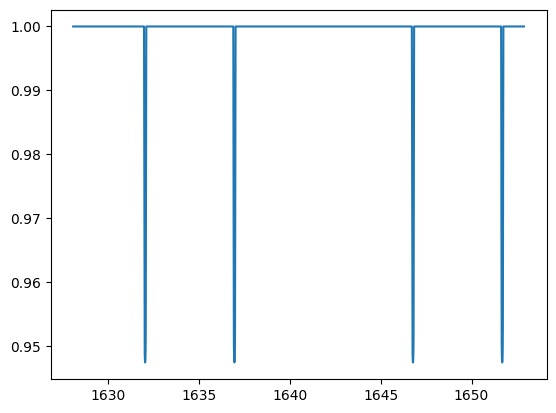

In [110]:
fl = calc_planet_lc(period, radius, b, a, rstar, time)
plt.plot(time, fl)

In [159]:
np.std(results.power)

17257.027903182

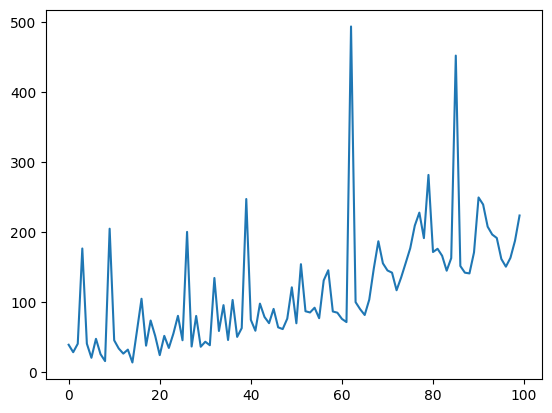

In [162]:
plt.plot(results.depth_snr)

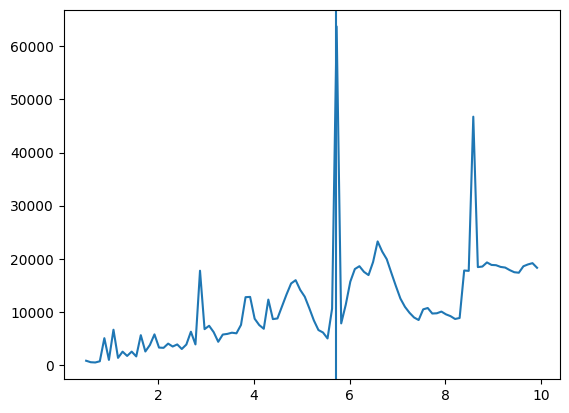

In [148]:
plt.plot(periods[::10], results.power)
plt.axvline(period)

In [38]:
radius/rstar

0.23977882881094242

In [ ]:
# right now this takes 4 hours. need a 100x decrease.
# well, if we do 10x decrease, that takes 25 minutes. can we get a factor of 6 decrease?
# what if we just assumed the injection / recovery was the same across the population...?
# that seems bad! it's informed by the data, not the underlying astrophysics
# around 2.74 s/it

In [21]:
flux

array([11179.74511719, 11175.11328125, 11148.06933594, ...,
       11186.71191406, 11194.41699219, 11188.703125  ])

In [19]:
plt.plot(

array([3.30674107e+286, 3.30563615e+286, 3.29790091e+286, ...,
       1.37236058e+287, 1.37341430e+287, 1.37282171e+287])

In [17]:
print(i)

0


# then: calculate occurrence rate!
- show an equation that demonstrates all the multiplicative factors and how they relate
- plot the histograms demonstrating the occurrence rate (with error bars!) of planets as a function of, e..g, orbital period
- demonstrate that this lines up or doesn't line up with the expectations from the literature
- if these are their own notebooks: the TIKE angle is